In [1]:
# Imports
import torch
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import (
    DataLoader,
)  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For nice progress bar!
import numpy as np

In [2]:
# Simple CNN
class CNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=8,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        self.fc1 = nn.Linear(16 * 7 * 7, 250) # replace this with siren.
        self.fc2 = nn.Linear(250,250)
        self.fc3 = nn.Linear(250, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x)) # replace this with siren.
        x = F.relu(self.fc2(x))
        x = self.fc2(x)
        return x

In [3]:
device = torch.device('cuda')
# Hyperparameters
in_channels = 1
num_classes = 10
learning_rate = 3e-4 # karpathy's constant
batch_size = 64
num_epochs = 3

In [4]:
# Load Data
train_dataset = datasets.MNIST(
    root="dataset/", train=True, transform=transforms.ToTensor(), download=True
)
test_dataset = datasets.MNIST(
    root="dataset/", train=False, transform=transforms.ToTensor(), download=True
)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 122718236.21it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 39664601.78it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25626086.69it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19990061.67it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [5]:
# Initialize network
model_relu = CNN(in_channels=in_channels, num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_relu.parameters(), lr=learning_rate)

In [6]:
# Train Network
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model_relu(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

100%|██████████| 938/938 [00:08<00:00, 105.45it/s]


In [7]:
# Check accuracy on training & test to see how good our model
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    model.train()
    return num_correct / num_samples


print(f"Accuracy on training set: {check_accuracy(train_loader, model_relu)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model_relu)*100:.2f}")

Accuracy on training set: 96.36
Accuracy on test set: 96.54


In [8]:
def compute_gradient (func,inp, **kwargs):
    inp.requires_grad = True
    loss = func(inp, **kwargs)
    loss.backward()
    inp.requires_grad = False
    return inp.grad.data

In [9]:
def func(inp, model = None, target = None):
    out = model(inp)
    loss = torch.nn.functional.nll_loss(out,torch.LongTensor([target]).to(device))
    #print(f"Loss:  {loss.item()}")
    return loss

In [10]:
def fgsm (tensor, model, eps = 1e-3):
  new_tensor = tensor.unsqueeze(0).detach().clone()
  new_tensor = new_tensor.to(device=device)
  orig_prediction = model(new_tensor).argmax()

  model.zero_grad()
  grad = compute_gradient(func, new_tensor, model = model, target = orig_prediction.item())
  new_tensor = new_tensor + eps*grad.sign()
  new_prediction = model(new_tensor).argmax()

  return new_tensor, new_prediction

In [11]:
def pgd_linf (tensor, model, eps = 1e-3, step_size = 1e4, n_iter = 40):
  new_tensor = tensor.unsqueeze(0).detach().clone()
  new_tensor = new_tensor.to(device=device)
  noise = torch.zeros_like(new_tensor)
  orig_prediction = model(new_tensor).argmax()

  for i in range(n_iter):
    model.zero_grad()
    grad = compute_gradient(func, new_tensor+noise, model = model, target = orig_prediction.item())
    noise = torch.clamp(noise+step_size*grad.sign(), -1*eps,eps)


  new_prediction = model(new_tensor+noise).argmax()

  return new_tensor+noise, new_prediction

In [27]:
def norms(Z):
  return Z.view(Z.shape[0], -1).norm(dim=1)[:,None,None,None]

def pgd_l2 (tensor, model, eps = 1e-3, step_size = 1e4, n_iter = 40):
  new_tensor = tensor.unsqueeze(0).detach().clone()
  new_tensor = new_tensor.to(device=device)
  noise = torch.zeros_like(new_tensor)
  orig_prediction = model(new_tensor).argmax()

  for i in range(n_iter):
    model.zero_grad()
    grad = compute_gradient(func, new_tensor+noise, model = model, target = orig_prediction.item())
    noise += step_size*grad.detach()/norms(grad.detach())
    noise = torch.min(torch.max(noise.detach(), -new_tensor), 1-new_tensor)
    noise *= eps/norms(noise.detach()).clamp(min = eps)

  new_prediction = model(new_tensor+noise).argmax()

  return new_tensor+noise, new_prediction


In [13]:
def attack (tensor, model, eps = 1e-3, n_iter = 5000):
    number = 5000
    new_tensor = tensor.unsqueeze(0).detach().clone()
    new_tensor = new_tensor.to(device = device)
    orig_prediction = model(new_tensor).argmax()
    #print(f"Original Prediction: {orig_prediction.item()}")

    for i in tqdm(range(n_iter)):
        model.zero_grad()

        grad = compute_gradient(func, new_tensor, model = model, target = orig_prediction.item())
        #new_tensor = torch.clamp(new_tensor + eps * grad.sign(), -2, 2)
        new_tensor = new_tensor + eps * grad.sign()
        new_prediction = model(new_tensor).argmax()

        if new_prediction != orig_prediction:
            #print(f"New Prediction: {new_prediction.item()}")
            number = i
            break
    return number

In [12]:
num1 = attack(train_dataset[0][0], model_relu)
num1

  1%|          | 42/5000 [00:00<00:21, 232.18it/s]


42

In [14]:
# now its time for siren.
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.

    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a
    # hyperparameter.

    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30,is_linear = False):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        self.is_linear = is_linear
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        if self.is_linear:
          return (self.omega_0 * self.linear(input))
        return torch.sin(self.omega_0 * self.linear(input))

    def forward_with_intermediate(self, input):
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate


class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False,
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()

        self.net = []
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)

                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()

                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else:
                x = layer(x)

                if retain_grad:
                    x.retain_grad()

            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

In [15]:
# Simple CNN
class siren_updated_CNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(siren_updated_CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=8,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        #self.fc1 = nn.Linear(16 * 7 * 7, 250) # replace this with siren.
        self.fc1 = SineLayer(16 * 7 * 7, 250, is_first=True, omega_0=30)
        self.fc2 = SineLayer(250, 250, is_first=False, omega_0=30)
        self.fc3 = SineLayer(250,num_classes, is_first = False)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        #x = F.relu(self.fc1(x)) # replace this with siren.
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [16]:
# Initialize network
model_siren_updated = siren_updated_CNN(in_channels=in_channels, num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_siren_updated.parameters(), lr=learning_rate)

In [17]:
# Train Network
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model_siren_updated(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

100%|██████████| 938/938 [00:09<00:00, 101.15it/s]


In [18]:
print(f"Accuracy on training set: {check_accuracy(train_loader, model_siren_updated)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model_siren_updated)*100:.2f}")

Accuracy on training set: 98.06
Accuracy on test set: 97.56


In [18]:
num1 = attack(train_dataset[0][0], model_siren_updated)
num1

100%|██████████| 5000/5000 [00:11<00:00, 428.39it/s]


5000

In [19]:
def new_compute_avg_n_iter_test (model_1, model_2):
    sum_1 = 0
    sum_2 = 0
    counter = 0
    i = 0
    while(counter<100):
        model_1_prediction = model_1(test_dataset[i][0].unsqueeze(0).to(device)).argmax()
        model_2_prediction = model_2(test_dataset[i][0].unsqueeze(0).to(device)).argmax()
        actual = test_dataset[i][1]
        print(counter)
        if (model_1_prediction == actual and model_2_prediction == actual):
            sum_1 += attack(test_dataset[i][0], model_1)
            sum_2 += attack(test_dataset[i][0], model_2)
            counter += 1
        i += 1
    return sum_1/100, sum_2/100

In [20]:
def fgsm_accuracy (model_1, model_2):
  sum_1 = 0
  sum_2 = 0
  counter = 0
  i = 0
  while(counter<100):
    model_1_prediction = model_1(test_dataset[i][0].unsqueeze(0).to(device)).argmax()
    model_2_prediction = model_2(test_dataset[i][0].unsqueeze(0).to(device)).argmax()
    actual = test_dataset[i][1]
    if (model_1_prediction == actual and model_2_prediction == actual):
            counter += 1
            model_1_fgsm, model_1_prediction_new = fgsm(test_dataset[i][0], model_1, eps = 0.15)
            model_2_fgsm, model_2_prediction_new = fgsm(test_dataset[i][0], model_2, eps = 0.15)
            if (model_1_prediction_new == actual):
              sum_1 += 1
            if (model_2_prediction_new == actual):
              sum_2 += 1
    i += 1
  return sum_1, sum_2

In [21]:
def pgd_linf_accuracy (model_1, model_2):
  sum_1 = 0
  sum_2 = 0
  counter = 0
  i = 0
  while(counter<100):
    model_1_prediction = model_1(test_dataset[i][0].unsqueeze(0).to(device)).argmax()
    model_2_prediction = model_2(test_dataset[i][0].unsqueeze(0).to(device)).argmax()
    actual = test_dataset[i][1]
    if (model_1_prediction == actual and model_2_prediction == actual):
            counter += 1
            model_1_fgsm, model_1_prediction_new = pgd_linf(test_dataset[i][0], model_1, eps = 0.25, step_size = 1e-2)
            model_2_fgsm, model_2_prediction_new = pgd_linf(test_dataset[i][0], model_2, eps = 0.25, step_size = 1e-2)
            if (model_1_prediction_new == actual):
              sum_1 += 1
            if (model_2_prediction_new == actual):
              sum_2 += 1
    i += 1
  return sum_1, sum_2

In [34]:
def pgd_l2_accuracy (model_1, model_2):
  sum_1 = 0
  sum_2 = 0
  counter = 0
  i = 0
  while(counter<100):
    model_1_prediction = model_1(test_dataset[i][0].unsqueeze(0).to(device)).argmax()
    model_2_prediction = model_2(test_dataset[i][0].unsqueeze(0).to(device)).argmax()
    actual = test_dataset[i][1]
    if (model_1_prediction == actual and model_2_prediction == actual):
            counter += 1
            model_1_fgsm, model_1_prediction_new = pgd_l2(test_dataset[i][0], model_1, eps = 3, step_size = 0.1)
            model_2_fgsm, model_2_prediction_new = pgd_l2(test_dataset[i][0], model_2, eps = 3, step_size = 0.1)
            if (model_1_prediction_new == actual):
              sum_1 += 1
            if (model_2_prediction_new == actual):
              sum_2 += 1
    i += 1
  return sum_1, sum_2

In [53]:
fgsm_accuracy(model_relu, model_siren_updated)

(22, 64)

In [40]:
pgd_linf_accuracy(model_relu, model_siren_updated)

(1, 46)

In [35]:
pgd_l2_accuracy(model_relu, model_siren_updated)

(8, 61)

In [36]:
import matplotlib.pyplot as plt

In [37]:
x = test_dataset[3][0]

In [55]:
y,pred = pgd_l2(x, model_siren_updated, eps=2, step_size = 1e-1)

In [56]:
y.shape

torch.Size([1, 1, 28, 28])

In [57]:
y = y.squeeze(0)

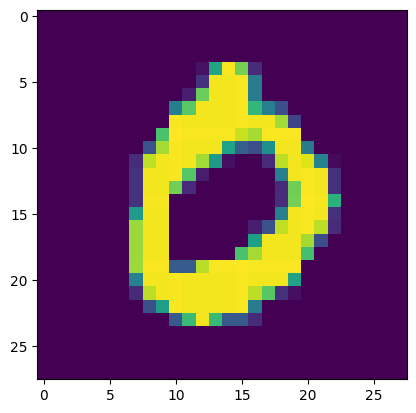

In [58]:
plt.imshow(np.transpose(x.cpu().numpy(), (1, 2, 0)))

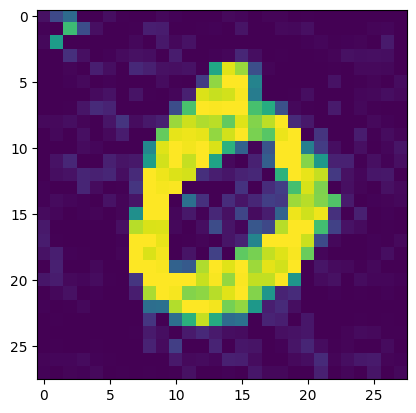

In [59]:
plt.imshow(np.transpose(y.cpu().numpy(), (1, 2, 0)))


In [60]:
pred

tensor(9, device='cuda:0')